# 01- Multiclass Classification 

In [1]:
import pandas as pd
from sklearn.utils import shuffle
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

On winters (October to April) I go to the Gym on Mondays, Wednesdays, and Fridays at 8 AM, and Tuesdays and Thursdays at 9 AM.  The rest of the year, I go to the Gym on Mondays, Wednesdays, and Fridays at 6 AM, and Tuesdays and Thursdays at 7 AM.

I would like to train a Neural Network so that it automatically figures out this logic from past records of when I went to the Gym, so that I can program my cell phone to set an alarm that reminds me when I should go.

I collected a list of 3,000 observations where I recorded the Day, Month, Day of Week and Time at which I went to the Gym. We do not have a record whether it is winter or summer… and we hope that the neural network will figure this out.

The file "Sample Data.xlsx" has the Excel file with the formulas used to create the synthetic data set. You can validate the logic if you are so inclined.  The data we will provide our neural network is in the file "Data.csv" 

In [3]:
raw_df = pd.read_csv('Data.csv')
raw_df = shuffle(raw_df)
raw_df.head()

Day  Month  WeekDay  Time
2866   29      4        4     7
1901   12      6        2     7
456    31      1        2     9
642    15      5        3     6
2091    2      2        7     8

In [4]:
raw_df.describe()

Day        Month      WeekDay         Time
count  3000.000000  3000.000000  3000.000000  3000.000000
mean     15.636667     6.494333     3.988000     7.440000
std       8.729150     3.489607     2.012264     1.123753
min       1.000000     1.000000     1.000000     6.000000
25%       8.000000     3.000000     2.000000     6.000000
50%      16.000000     6.000000     4.000000     8.000000
75%      23.000000    10.000000     6.000000     8.000000
max      31.000000    12.000000     7.000000     9.000000

The data does not have much variation in terms of ranges. We do not have a series that has very large numbers and a series that has very small numbers. Hence, we do not need to normalize the data. 

Lets create an X matrix that has the Day, Month and Weekday columns.  This will be our Features.  Lets create a Y matrix that has our Time. This will be our Labels.

For the Y labels, we will use One Hot encoding.  One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.  We have 24 categories for our classification problem (the hour for the alarm), and rather than provide a Y vector that has a value from 0 to 23, we will transform this into a matrix where a 1 will be placed in a column representing each of the 24 categories.

<img src="onehot.png">

We are using the numbers 0 through 23 as though they are simbols.  We could be using the labels "one", "two", "three", etc. rather than 0, 1, 2, etc... and the one-hot encoding would be exactly the same. 

In [5]:
X = raw_df[['Day', 'Month', 'WeekDay']]

In [6]:
Y = tf.one_hot(raw_df['Time'], 24).numpy()

In [7]:
print(X.shape, Y.shape)

(3000, 3) (3000, 24)


Split our data so that 80% is used for training and 20% is used for testing.

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [9]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

We will define a neural network that has 1 input layer, 2 hiden layers and a softmax layer. Softmax is a mathematical function that converts a vector of numbers into a vector of probabilities, where the probabilities of each value are proportional to the relative scale of each value in the vector.

The most common use of the softmax function in applied machine learning is in its use as an activation function in a neural network model. Specifically, the network is configured to output N values, one for each class in the classification task, and the softmax function is used to normalize the outputs, converting them from weighted sum values into probabilities that sum to one. Each value in the output of the softmax function is interpreted as the probability of membership for each class.

Since we are outputing 24 different values (for each hour), we use Softmax as the final layer.

In [10]:
alarm_model = keras.Sequential(
    [
        layers.Dense(20, activation='relu'),
        layers.Dense(20, activation='relu'),
        layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
        layers.Dense(24, activation='softmax')
    ]
)

alarm_model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=keras.metrics.CategoricalAccuracy()
)

The hyper parameters for this architecture are the number of layers, the activation functions used, the regularization used and where it is applied, the type of optimizer and the learning rate.  How did we come up with these values?  Experimentation. Remember that Machine Learning is an iterative process as illustrated in the following figure:

<img src="interativeprocess.png">

Lets try to train our model.  Since this is a multi-classification problem, we cannot use precission, recall or f1 score to measure the effectiveness of our model.  We will try to measure the effectiveness from a CategoricalAccuracy metric.  Categorial Accuracy measures how often predictions match one-hot labels - see https://www.tensorflow.org/api_docs/python/tf/keras/metrics/CategoricalAccuracy

In [11]:
alarm_results = alarm_model.fit(X_train, Y_train, batch_size=32, epochs = 200, verbose=2, validation_data=(X_test, Y_test))

Epoch 1/200
75/75 - 1s - loss: 3.4804 - categorical_accuracy: 0.2229 - val_loss: 2.2496 - val_categorical_accuracy: 0.2500
Epoch 2/200
75/75 - 0s - loss: 1.8443 - categorical_accuracy: 0.3017 - val_loss: 1.5576 - val_categorical_accuracy: 0.3350
Epoch 3/200
75/75 - 0s - loss: 1.4671 - categorical_accuracy: 0.3196 - val_loss: 1.4091 - val_categorical_accuracy: 0.3383
Epoch 4/200
75/75 - 0s - loss: 1.3913 - categorical_accuracy: 0.3429 - val_loss: 1.3515 - val_categorical_accuracy: 0.3883
Epoch 5/200
75/75 - 0s - loss: 1.3528 - categorical_accuracy: 0.3550 - val_loss: 1.3220 - val_categorical_accuracy: 0.3767
Epoch 6/200
75/75 - 0s - loss: 1.3200 - categorical_accuracy: 0.3713 - val_loss: 1.2834 - val_categorical_accuracy: 0.4167
Epoch 7/200
75/75 - 0s - loss: 1.2780 - categorical_accuracy: 0.3871 - val_loss: 1.2308 - val_categorical_accuracy: 0.4283
Epoch 8/200
75/75 - 0s - loss: 1.2435 - categorical_accuracy: 0.4046 - val_loss: 1.1905 - val_categorical_accuracy: 0.4517
Epoch 9/200
75/7

Epoch 68/200
75/75 - 0s - loss: 0.6042 - categorical_accuracy: 0.6538 - val_loss: 0.6152 - val_categorical_accuracy: 0.6600
Epoch 69/200
75/75 - 0s - loss: 0.6061 - categorical_accuracy: 0.6554 - val_loss: 0.6106 - val_categorical_accuracy: 0.6883
Epoch 70/200
75/75 - 0s - loss: 0.6051 - categorical_accuracy: 0.6546 - val_loss: 0.6058 - val_categorical_accuracy: 0.6800
Epoch 71/200
75/75 - 0s - loss: 0.6022 - categorical_accuracy: 0.6471 - val_loss: 0.6038 - val_categorical_accuracy: 0.7033
Epoch 72/200
75/75 - 0s - loss: 0.5982 - categorical_accuracy: 0.6617 - val_loss: 0.6011 - val_categorical_accuracy: 0.6950
Epoch 73/200
75/75 - 0s - loss: 0.5994 - categorical_accuracy: 0.6408 - val_loss: 0.5971 - val_categorical_accuracy: 0.6717
Epoch 74/200
75/75 - 0s - loss: 0.6008 - categorical_accuracy: 0.6600 - val_loss: 0.5956 - val_categorical_accuracy: 0.6717
Epoch 75/200
75/75 - 0s - loss: 0.5951 - categorical_accuracy: 0.6579 - val_loss: 0.5908 - val_categorical_accuracy: 0.6617
Epoch 76

Epoch 134/200
75/75 - 0s - loss: 0.5027 - categorical_accuracy: 0.7196 - val_loss: 0.5074 - val_categorical_accuracy: 0.7267
Epoch 135/200
75/75 - 0s - loss: 0.4990 - categorical_accuracy: 0.7179 - val_loss: 0.4920 - val_categorical_accuracy: 0.7517
Epoch 136/200
75/75 - 0s - loss: 0.5017 - categorical_accuracy: 0.7179 - val_loss: 0.4926 - val_categorical_accuracy: 0.7467
Epoch 137/200
75/75 - 0s - loss: 0.4978 - categorical_accuracy: 0.7129 - val_loss: 0.4897 - val_categorical_accuracy: 0.7483
Epoch 138/200
75/75 - 0s - loss: 0.4941 - categorical_accuracy: 0.7067 - val_loss: 0.4911 - val_categorical_accuracy: 0.7200
Epoch 139/200
75/75 - 0s - loss: 0.4914 - categorical_accuracy: 0.7217 - val_loss: 0.4853 - val_categorical_accuracy: 0.7683
Epoch 140/200
75/75 - 0s - loss: 0.4886 - categorical_accuracy: 0.7262 - val_loss: 0.5002 - val_categorical_accuracy: 0.7250
Epoch 141/200
75/75 - 0s - loss: 0.4873 - categorical_accuracy: 0.7387 - val_loss: 0.4918 - val_categorical_accuracy: 0.7300


Epoch 200/200
75/75 - 0s - loss: 0.3720 - categorical_accuracy: 0.7479 - val_loss: 0.3739 - val_categorical_accuracy: 0.7617


In [12]:
def plot_metrics(history):
  metrics = ['loss', 'categorical_accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

We still measure Loss, along Categorical Accuracy.  So long as our training reduces loss and our Categorical Accuracy increases, we are doing fine. 

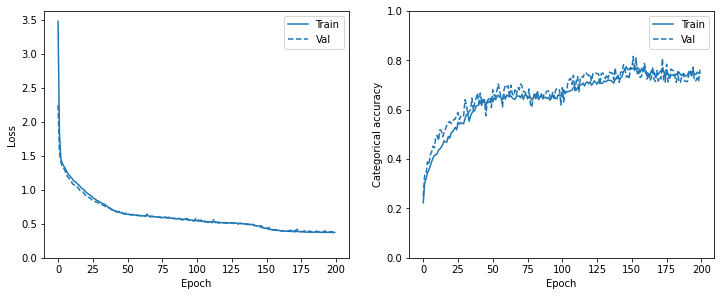

In [13]:
plot_metrics(alarm_results)

Our model is well behaved.  Validation and Training losses are constantly decreasing, and hence we do not have overfitting. Accuracy is increasing, so we are learning.

Our model should be producing a series of probabilities.  The output for each prediction should be a set of 24 probabilities, and the highest probability is our prediction.  Let’s see what the result of the prediction with our test data is.

In [14]:
Y_pred = alarm_model.predict(X_test)

In [15]:
Y_pred

array([[1.2124154e-09, 4.8635616e-09, 1.6769687e-09, ..., 6.3371266e-12,
        3.4358583e-10, 2.7011346e-10],
       [1.8950142e-11, 1.2967045e-11, 2.8530533e-09, ..., 1.8368525e-13,
        2.0944671e-11, 5.8293604e-13],
       [3.6148012e-14, 1.4783205e-13, 6.6636568e-10, ..., 7.1677001e-13,
        2.7803443e-13, 8.6770123e-15],
       ...,
       [5.7672663e-16, 3.2112389e-17, 2.7393272e-12, ..., 5.0705200e-18,
        1.4958270e-18, 5.7405830e-21],
       [8.0296214e-09, 4.8329404e-08, 2.4813017e-08, ..., 1.8147722e-10,
        3.3775207e-09, 2.6357494e-09],
       [8.7468121e-16, 7.2388976e-16, 2.0000304e-09, ..., 1.7923211e-15,
        2.7259068e-13, 1.1148441e-16]], dtype=float32)

To get a list of numbers we predicted, we need to convert these vectors of probabilities into a set of numbers, indicating which probability is larger. We can do this with the argmax function.  argmax returns the index with the largest value across axes of a tensor.  See https://www.tensorflow.org/api_docs/python/tf/math/argmax 

In [16]:
predictions = tf.argmax(Y_pred, axis=1)

In [17]:
predictions

<tf.Tensor: shape=(600,), dtype=int64, numpy=
array([6, 7, 9, 9, 8, 6, 7, 8, 8, 7, 8, 9, 6, 6, 6, 6, 7, 6, 8, 7, 7, 7,
       7, 6, 8, 7, 6, 8, 8, 8, 9, 6, 9, 8, 9, 8, 9, 9, 6, 8, 6, 9, 6, 6,
       9, 9, 8, 8, 8, 8, 6, 6, 9, 8, 6, 9, 6, 7, 6, 7, 7, 6, 7, 8, 6, 9,
       7, 8, 8, 8, 9, 7, 7, 6, 7, 9, 6, 7, 8, 6, 9, 7, 9, 9, 7, 8, 6, 7,
       8, 8, 8, 6, 9, 6, 8, 8, 9, 6, 6, 6, 8, 6, 6, 6, 8, 9, 6, 8, 8, 7,
       9, 8, 8, 9, 8, 9, 7, 7, 8, 7, 7, 9, 7, 7, 7, 6, 7, 8, 7, 7, 8, 8,
       8, 6, 8, 6, 6, 8, 7, 6, 9, 6, 6, 6, 9, 7, 9, 9, 7, 6, 7, 8, 7, 6,
       6, 8, 8, 7, 8, 8, 7, 8, 8, 9, 9, 8, 7, 6, 8, 8, 6, 9, 7, 6, 8, 6,
       8, 6, 6, 8, 9, 9, 8, 8, 8, 7, 9, 9, 8, 7, 9, 7, 7, 6, 8, 8, 6, 8,
       9, 8, 8, 6, 6, 7, 6, 6, 8, 6, 9, 6, 9, 8, 6, 6, 8, 8, 6, 6, 9, 6,
       6, 6, 9, 8, 7, 6, 9, 7, 7, 6, 6, 7, 7, 7, 9, 6, 8, 7, 7, 7, 8, 8,
       6, 9, 9, 8, 6, 8, 8, 7, 8, 9, 7, 9, 7, 6, 6, 7, 6, 6, 9, 8, 7, 6,
       6, 8, 8, 9, 8, 6, 8, 8, 6, 6, 7, 9, 8, 8, 8, 8, 8, 9, 8, 8, 7, 9,
     

Our original labels are a one-hot vector. We can use the same argmax function to determine the original labels as well. 

In [18]:
original = tf.argmax(Y_test, axis=1)

Now, let's try to print our those cases where our algorithm failed to predict the correct class.  

In [19]:
length = len(Y_test)
for i in range(length):
    if(original[i].numpy() != predictions[i].numpy()):
        print("Value ", original[i].numpy(), " was predicted as ", predictions[i].numpy())

Value  7  was predicted as  6
Value  7  was predicted as  6
Value  6  was predicted as  7
Value  9  was predicted as  8
Value  7  was predicted as  6
Value  7  was predicted as  6
Value  6  was predicted as  7
Value  7  was predicted as  6
Value  9  was predicted as  8
Value  6  was predicted as  7
Value  6  was predicted as  7
Value  7  was predicted as  6
Value  9  was predicted as  8
Value  8  was predicted as  9
Value  7  was predicted as  6
Value  8  was predicted as  9
Value  9  was predicted as  8
Value  8  was predicted as  9
Value  9  was predicted as  8
Value  8  was predicted as  9
Value  6  was predicted as  7
Value  6  was predicted as  7
Value  9  was predicted as  8
Value  6  was predicted as  7
Value  6  was predicted as  7
Value  6  was predicted as  7
Value  9  was predicted as  8
Value  6  was predicted as  7
Value  6  was predicted as  7
Value  9  was predicted as  8
Value  8  was predicted as  9
Value  7  was predicted as  6
Value  6  was predicted as  7
Value  8  

We can plot a confusion matrix to visualize what the model is doing. 

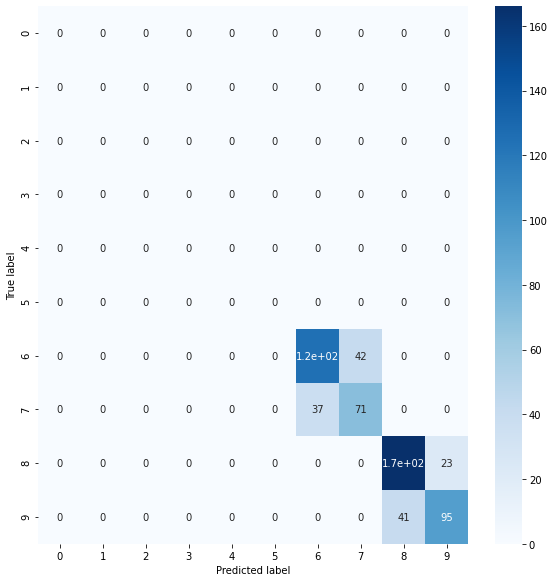

In [20]:
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(tf.math.confusion_matrix(original, predictions), annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Our model is consistently misclassifying 7 with 6 and 8 with 9.... it has not figured out that winter vs. non-winter makes all the difference.

Our model has an accuracy of 77%.  This is an application where longer training may pay off, since the loss is decreasing and the accuracy is increasing.  lets try retraining the model with 400 epochs to see how the performance improves!  You may be surprised by the results.

In [21]:
alarm_results = alarm_model.fit(X_train, Y_train, batch_size=32, epochs = 400, verbose=2, validation_data=(X_test, Y_test))

Epoch 1/400
75/75 - 0s - loss: 0.3683 - categorical_accuracy: 0.7308 - val_loss: 0.3743 - val_categorical_accuracy: 0.7150
Epoch 2/400
75/75 - 0s - loss: 0.3723 - categorical_accuracy: 0.7387 - val_loss: 0.3732 - val_categorical_accuracy: 0.7150
Epoch 3/400
75/75 - 0s - loss: 0.3727 - categorical_accuracy: 0.7454 - val_loss: 0.3803 - val_categorical_accuracy: 0.7117
Epoch 4/400
75/75 - 0s - loss: 0.3711 - categorical_accuracy: 0.7467 - val_loss: 0.3686 - val_categorical_accuracy: 0.7567
Epoch 5/400
75/75 - 0s - loss: 0.3693 - categorical_accuracy: 0.7513 - val_loss: 0.3844 - val_categorical_accuracy: 0.7483
Epoch 6/400
75/75 - 0s - loss: 0.3690 - categorical_accuracy: 0.7375 - val_loss: 0.3707 - val_categorical_accuracy: 0.7400
Epoch 7/400
75/75 - 0s - loss: 0.3723 - categorical_accuracy: 0.7633 - val_loss: 0.3686 - val_categorical_accuracy: 0.7483
Epoch 8/400
75/75 - 0s - loss: 0.3682 - categorical_accuracy: 0.7471 - val_loss: 0.3697 - val_categorical_accuracy: 0.7333
Epoch 9/400
75/7

Epoch 68/400
75/75 - 0s - loss: 0.3539 - categorical_accuracy: 0.7788 - val_loss: 0.3483 - val_categorical_accuracy: 0.7667
Epoch 69/400
75/75 - 0s - loss: 0.3487 - categorical_accuracy: 0.7796 - val_loss: 0.3554 - val_categorical_accuracy: 0.7450
Epoch 70/400
75/75 - 0s - loss: 0.3477 - categorical_accuracy: 0.7663 - val_loss: 0.3511 - val_categorical_accuracy: 0.7550
Epoch 71/400
75/75 - 0s - loss: 0.3478 - categorical_accuracy: 0.7608 - val_loss: 0.3484 - val_categorical_accuracy: 0.7567
Epoch 72/400
75/75 - 0s - loss: 0.3510 - categorical_accuracy: 0.7754 - val_loss: 0.3463 - val_categorical_accuracy: 0.7817
Epoch 73/400
75/75 - 0s - loss: 0.3470 - categorical_accuracy: 0.7642 - val_loss: 0.3593 - val_categorical_accuracy: 0.7517
Epoch 74/400
75/75 - 0s - loss: 0.3488 - categorical_accuracy: 0.7758 - val_loss: 0.3524 - val_categorical_accuracy: 0.7767
Epoch 75/400
75/75 - 0s - loss: 0.3460 - categorical_accuracy: 0.7738 - val_loss: 0.3448 - val_categorical_accuracy: 0.7683
Epoch 76

Epoch 134/400
75/75 - 0s - loss: 0.0842 - categorical_accuracy: 0.9996 - val_loss: 0.0836 - val_categorical_accuracy: 1.0000
Epoch 135/400
75/75 - 0s - loss: 0.0797 - categorical_accuracy: 1.0000 - val_loss: 0.0797 - val_categorical_accuracy: 1.0000
Epoch 136/400
75/75 - 0s - loss: 0.0758 - categorical_accuracy: 1.0000 - val_loss: 0.0766 - val_categorical_accuracy: 1.0000
Epoch 137/400
75/75 - 0s - loss: 0.0754 - categorical_accuracy: 1.0000 - val_loss: 0.0749 - val_categorical_accuracy: 1.0000
Epoch 138/400
75/75 - 0s - loss: 0.0705 - categorical_accuracy: 1.0000 - val_loss: 0.0700 - val_categorical_accuracy: 1.0000
Epoch 139/400
75/75 - 0s - loss: 0.0665 - categorical_accuracy: 1.0000 - val_loss: 0.0680 - val_categorical_accuracy: 1.0000
Epoch 140/400
75/75 - 0s - loss: 0.0646 - categorical_accuracy: 1.0000 - val_loss: 0.0674 - val_categorical_accuracy: 1.0000
Epoch 141/400
75/75 - 0s - loss: 0.0620 - categorical_accuracy: 1.0000 - val_loss: 0.0622 - val_categorical_accuracy: 1.0000


Epoch 200/400
75/75 - 0s - loss: 0.0259 - categorical_accuracy: 1.0000 - val_loss: 0.0261 - val_categorical_accuracy: 1.0000
Epoch 201/400
75/75 - 0s - loss: 0.0257 - categorical_accuracy: 1.0000 - val_loss: 0.0261 - val_categorical_accuracy: 1.0000
Epoch 202/400
75/75 - 0s - loss: 0.0256 - categorical_accuracy: 1.0000 - val_loss: 0.0258 - val_categorical_accuracy: 1.0000
Epoch 203/400
75/75 - 0s - loss: 0.0254 - categorical_accuracy: 1.0000 - val_loss: 0.0256 - val_categorical_accuracy: 1.0000
Epoch 204/400
75/75 - 0s - loss: 0.0252 - categorical_accuracy: 1.0000 - val_loss: 0.0254 - val_categorical_accuracy: 1.0000
Epoch 205/400
75/75 - 0s - loss: 0.0251 - categorical_accuracy: 1.0000 - val_loss: 0.0253 - val_categorical_accuracy: 1.0000
Epoch 206/400
75/75 - 0s - loss: 0.0249 - categorical_accuracy: 1.0000 - val_loss: 0.0250 - val_categorical_accuracy: 1.0000
Epoch 207/400
75/75 - 0s - loss: 0.0248 - categorical_accuracy: 1.0000 - val_loss: 0.0250 - val_categorical_accuracy: 1.0000


Epoch 266/400
75/75 - 0s - loss: 0.0127 - categorical_accuracy: 1.0000 - val_loss: 0.0126 - val_categorical_accuracy: 1.0000
Epoch 267/400
75/75 - 0s - loss: 0.0125 - categorical_accuracy: 1.0000 - val_loss: 0.0128 - val_categorical_accuracy: 1.0000
Epoch 268/400
75/75 - 0s - loss: 0.0123 - categorical_accuracy: 1.0000 - val_loss: 0.0124 - val_categorical_accuracy: 1.0000
Epoch 269/400
75/75 - 0s - loss: 0.0122 - categorical_accuracy: 1.0000 - val_loss: 0.0126 - val_categorical_accuracy: 1.0000
Epoch 270/400
75/75 - 0s - loss: 0.0121 - categorical_accuracy: 1.0000 - val_loss: 0.0121 - val_categorical_accuracy: 1.0000
Epoch 271/400
75/75 - 0s - loss: 0.0118 - categorical_accuracy: 1.0000 - val_loss: 0.0120 - val_categorical_accuracy: 1.0000
Epoch 272/400
75/75 - 0s - loss: 0.0119 - categorical_accuracy: 1.0000 - val_loss: 0.0122 - val_categorical_accuracy: 1.0000
Epoch 273/400
75/75 - 0s - loss: 0.0116 - categorical_accuracy: 1.0000 - val_loss: 0.0117 - val_categorical_accuracy: 1.0000


Epoch 332/400
75/75 - 0s - loss: 0.0081 - categorical_accuracy: 1.0000 - val_loss: 0.0082 - val_categorical_accuracy: 1.0000
Epoch 333/400
75/75 - 0s - loss: 0.0081 - categorical_accuracy: 1.0000 - val_loss: 0.0082 - val_categorical_accuracy: 1.0000
Epoch 334/400
75/75 - 0s - loss: 0.0080 - categorical_accuracy: 1.0000 - val_loss: 0.0082 - val_categorical_accuracy: 1.0000
Epoch 335/400
75/75 - 0s - loss: 0.0080 - categorical_accuracy: 1.0000 - val_loss: 0.0081 - val_categorical_accuracy: 1.0000
Epoch 336/400
75/75 - 0s - loss: 0.0080 - categorical_accuracy: 1.0000 - val_loss: 0.0081 - val_categorical_accuracy: 1.0000
Epoch 337/400
75/75 - 0s - loss: 0.0080 - categorical_accuracy: 1.0000 - val_loss: 0.0081 - val_categorical_accuracy: 1.0000
Epoch 338/400
75/75 - 0s - loss: 0.0080 - categorical_accuracy: 1.0000 - val_loss: 0.0081 - val_categorical_accuracy: 1.0000
Epoch 339/400
75/75 - 0s - loss: 0.0080 - categorical_accuracy: 1.0000 - val_loss: 0.0081 - val_categorical_accuracy: 1.0000


Epoch 398/400
75/75 - 0s - loss: 0.0059 - categorical_accuracy: 1.0000 - val_loss: 0.0059 - val_categorical_accuracy: 1.0000
Epoch 399/400
75/75 - 0s - loss: 0.0058 - categorical_accuracy: 1.0000 - val_loss: 0.0058 - val_categorical_accuracy: 1.0000
Epoch 400/400
75/75 - 0s - loss: 0.0058 - categorical_accuracy: 1.0000 - val_loss: 0.0058 - val_categorical_accuracy: 1.0000


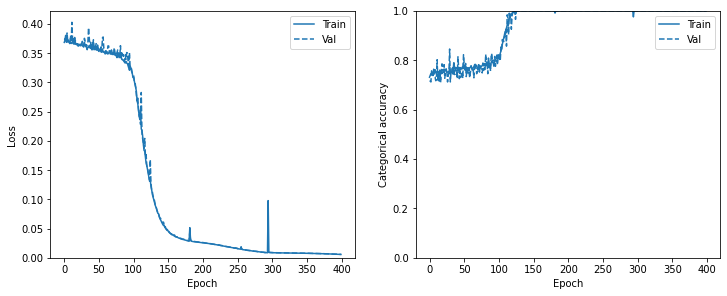

In [22]:
plot_metrics(alarm_results)

The neural network figured out the winter vs. non-winter issue and the accuracy is now 100%.